In [1]:
import xarray as xr
import dask
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate
import tqdm
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pickle
import pandas as pd
import itertools
from numba import jit
colors =itertools.cycle(plt.get_cmap('magma')(np.linspace(0.25,0.75, 3)))
colorA=next(colors)

colorC=next(colors)
colorB=next(colors)
#import basemap
#fig sizes
Wf=(190/25.4)
Hf=(230/25.4)
Wf4=(95/25.4)
Hf4=(115/25.4)

color1='#00CD6C'#green
color2='#AF58BA'#purple
color3='#FFC61E' #yello
color4='#009ADE' #blue
color5='#F28522' #orange
color6='#A0B1BA' #gray
color7='#A6761D'#brown
color8='#FF1F5B' #red

In [31]:
cluster_data_path = '/home/amh001/space_fs7/DATA/NEP36-CanOE/From_Andrew/output_data/'
cluster_data_path = './'

cluster_files = [ f'{cluster_data_path}/output_data/cluster_{i}.nc' for i in range(8) ]
clusters_ds = [ xr.open_dataset(file, chunks={'time':439}, engine='h5netcdf') for file in cluster_files ]

In [32]:
#cluster_ds

In [40]:
plot_clusters = [5, 7]
cluster_names = {5:'Shallows', 7:'Canyons'}

In [41]:
for cluster_ds in clusters_ds:
    cluster_ds['ALK_norm'] = 32.5*cluster_ds['ALK']/cluster_ds['S']
    cluster_ds['DIC_norm'] = 32.5*cluster_ds['DIC']/cluster_ds['S']

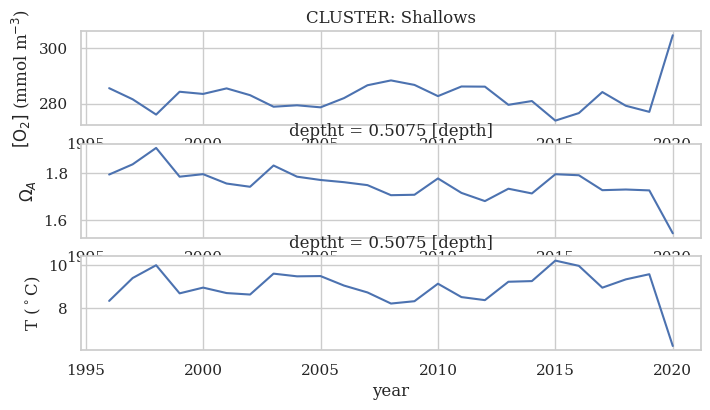

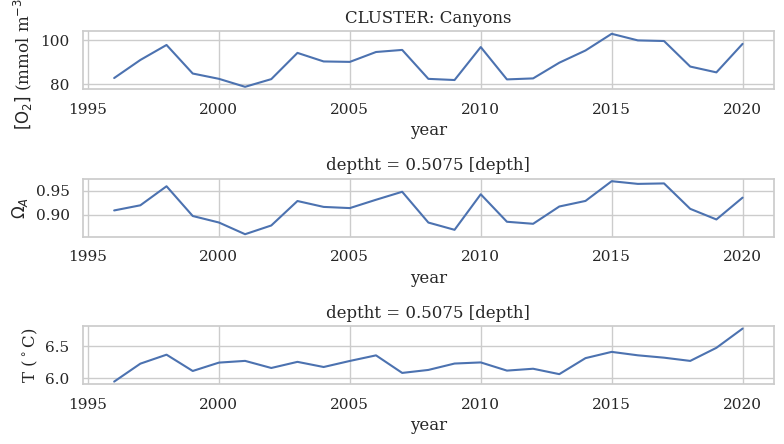

In [42]:
# Plot timeseries of all the relevant variables

timeseries_vars = [
    'O2',
    'OmegaA',
    'T',
    # 'ALK_norm',
    # 'DIC_norm',
    # 'ALK',
    # 'DIC',
]


long_names = dict(
    O2=r"$[\mathrm{O}_2]$",
    OmegaA="$\Omega_A$",
    T="T"
    # ALK_norm="Normalized Alkalinity",
    # DIC_norm="Normalized DIC",
    # ALK="Alkalinity",
    # DIC="DIC",
)

units = dict(
    O2="mmol m$^{-3}$",
    OmegaA="(non-dimensional)",
    T="$^\circ$C",
    
    # ALK_norm="mmolk m$^{-3}$",
    # DIC_norm="mmolk m$^{-3}$",
    # ALK="mmolk m$^{-3}$",
    # DIC="mmolk m$^{-3}$"
)


for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))    
        for idx, var in enumerate(timeseries_vars):        
            plt.subplot(7,1,idx+1)
            cluster_ds[var].groupby('time.year').mean('time').mean('stacked_y_x').plot()
            if var=='OmegaA':
                plt.ylabel(f"{long_names[var]}")
            else:
                plt.ylabel(f"{long_names[var]} ({units[var]})")
            if idx == 0:
                plt.title(f'CLUSTER: '+ cluster_names[cluster_label])# {cluster_label}')
plt.tight_layout()   

0
1
2


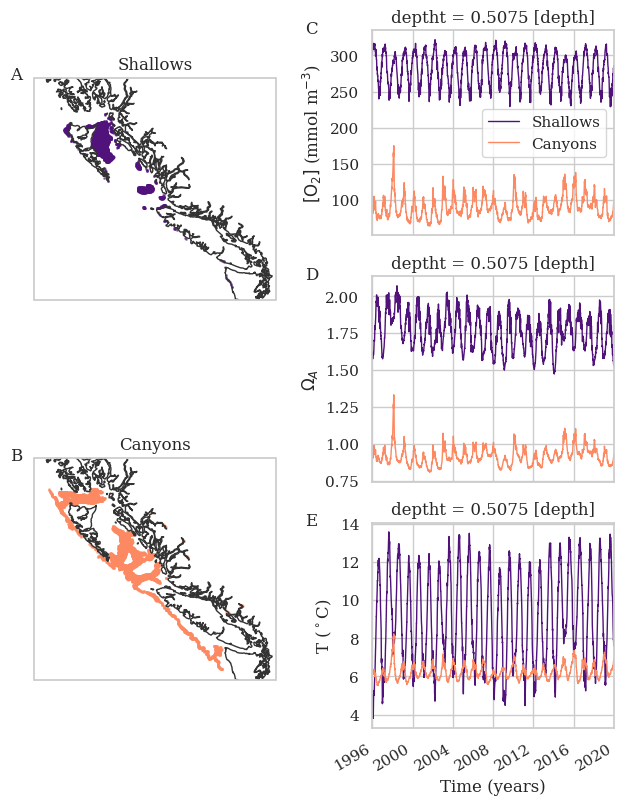

In [43]:
import seaborn as sns
sns.set('notebook')
sns.set_style('whitegrid')
#fig, axs = plt.subplots(3, 1, sharex=True,figsize=(Wf,Hf))
fig=plt.figure(figsize=(Wf,Hf))
################
subpanel = ['A','B','C','D', 'E']
plt.rcParams["font.family"] = "Serif"
colors=[colorA,colorB]
p=1

at=-0.1
bt=1.05
#ax = fig.add_subplot(2,2,p)
for ii in np.arange(2):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(2,2,p, projection=ccrs.Miller())
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor="0.2")
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()

    plt.scatter(x=nlon, y=nlat,
                color=colors[ii],
                s=1,
                alpha=0.5,
                transform=ccrs.PlateCarree()) ## Important

    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
    plt.title(cluster_names[cluster_id])
###############
at=-0.28
bt=1.05

for i, var in enumerate(timeseries_vars):
    print(i)
    if i==0:
        p=2
    if i==1:
        p=4
    if i==2:
        p=6
    ax = fig.add_subplot(3,2,p)

    cluster_id = plot_clusters[0]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1,color=colorA)
    cluster_id = plot_clusters[1]
    clusters_ds[cluster_id][var].mean('stacked_y_x').plot(label=cluster_names[cluster_id], ax=ax, linewidth=1, color=colorB,zorder=2)
    #ax.set_ylabel(f"{long_names[var]}\n({units[var]})")
    if i != 2:
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if i == 0:
        ax.legend()
    if var=='OmegaA':
        ax.set_ylabel(f"{long_names[var]}")
    else:
        ax.set_ylabel(f"{long_names[var]} ({units[var]})")
    ax.grid('on')
    #ax.set_title(f'({subpanel[i]})')
    ax.text(at, bt, subpanel[i+2], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)

    plt.axis('tight')
    X=ax.get_xticks()
    #print(X)
    plt.xlim([X[1], X[-2]])
plt.xlabel('Time (years)')
plt.subplots_adjust(wspace=0.4)
plt.savefig('cluster_timeseries.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)      

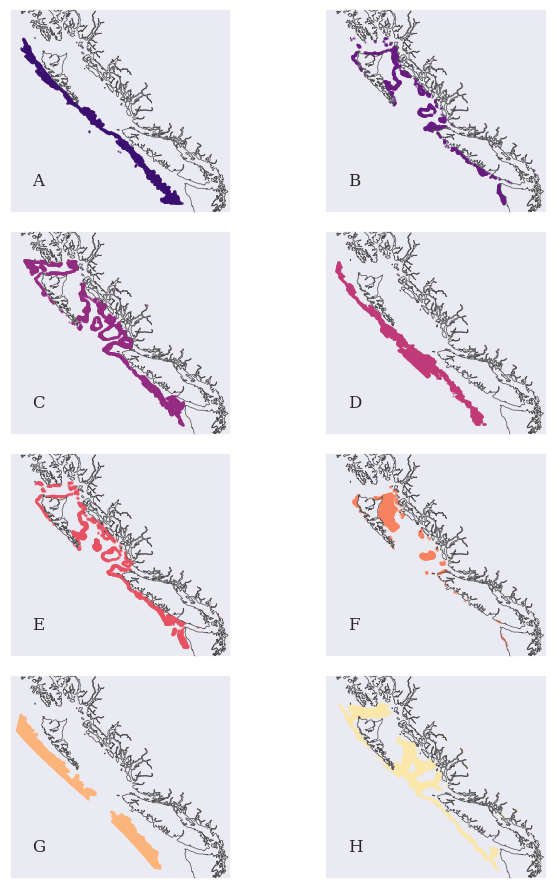

In [44]:
fig=plt.figure(figsize=(Wf,Hf))
################
colors =itertools.cycle(plt.get_cmap('magma')(np.linspace(0.2,0.95, 8)))
sns.set_style('darkgrid')
subpanel = ['A','B','C','D', 'E', 'F', 'G','H','I','J']
plt.rcParams["font.family"] = "Serif"
#colors=[colorA,colorB]
p=1

at=0.1
bt=.2
#ax = fig.add_subplot(2,2,p)
for ii in np.arange(8):
    if ii==0:
        p=1
    else:
        p=3
    cluster_id = ii#plot_clusters[ii]
    nlat=clusters_ds[cluster_id][var][0,:].nav_lat.values
    nlon=clusters_ds[cluster_id][var][0,:].nav_lon.values
    ax = fig.add_subplot(4,2,ii+1, projection=ccrs.Miller())
    #ax.set_global()

    ax.add_feature(cfeature.COASTLINE, edgecolor='0.3', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, edgecolor="0.2")
    #ax.gridlines()

    plt.scatter(x=nlon, y=nlat,
                color=next(colors),
                s=.5,
                alpha=0.5,
                transform=ccrs.PlateCarree()) ## Important

    lat1=56;lat2=47;lon1=-135;lon2=-122
    ax.set_extent([ lon1, lon2, lat1,lat2], crs=ccrs.PlateCarree())
    ax.text(at, bt, subpanel[ii], transform=ax.transAxes,  va='top', fontweight='normal',zorder=1000)
#plt.subplots_adjust(wspace=-0.1)
plt.tight_layout()
plt.savefig('clusters.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)

In [46]:
# Split by upwelling season
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.7,
    'density':True,
    'bins':200,
    'edgecolor':'None'
}

def filter_by_season_and_values(ds,month_range):       
    ds_out = ds.where(ds['time.month'].isin(month_range),drop=True)
    return ds_out

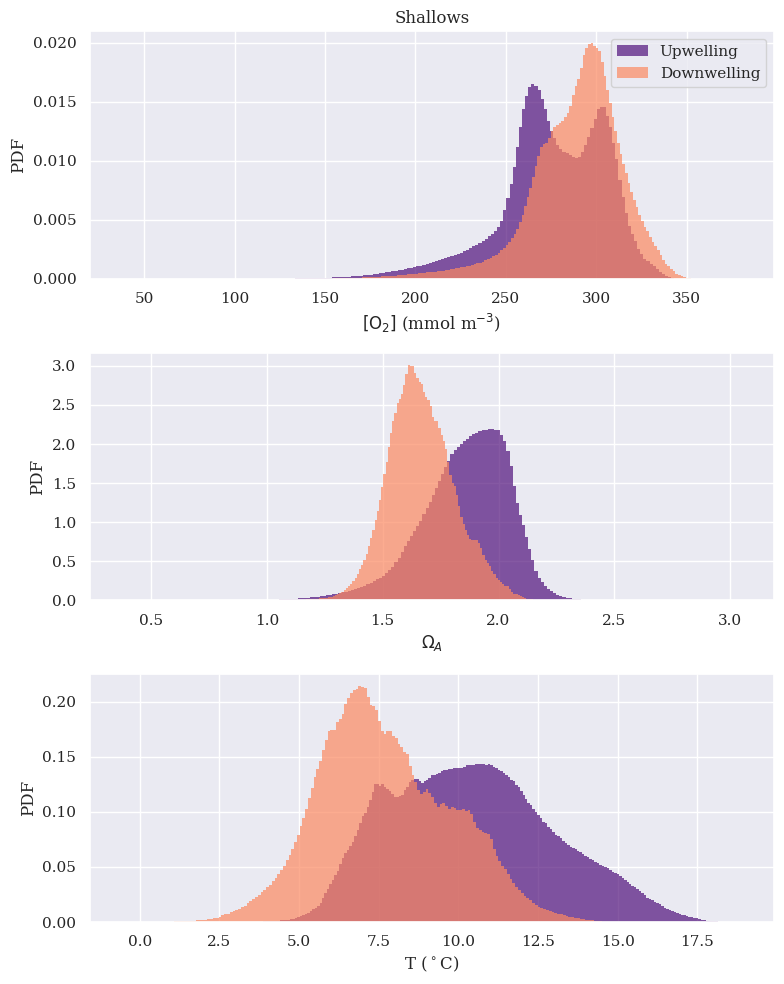

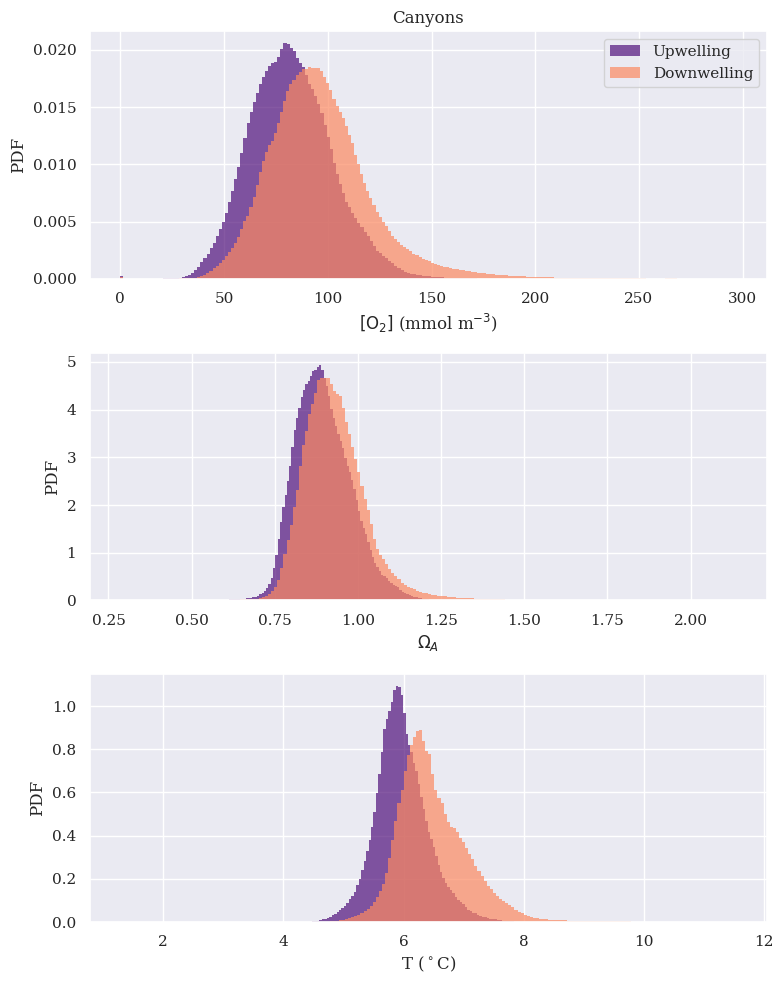

In [48]:
#font = {'family:':'sans serif',
 #       'weight' : 'bold',
  #      'size'   : 12}

#matplotlib.rc('font', **font)

downwelling = {}
upwelling = {}
#sns.set_style('ticks')

for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        plt.figure(figsize=(8,10))
        ds_months = cluster_ds.groupby('time.month')    
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)
        downwelling[cluster_label] = downwelling_ds.copy()
        upwelling[cluster_label] = upwelling_ds.copy()
        for idx, var in enumerate(timeseries_vars):         
            ax=plt.subplot(3,1,idx+1)
            plt.hist(upwelling_ds[var].to_numpy().flatten(),label='Upwelling', **hist_kwargs, color=colorA)
            plt.hist(downwelling_ds[var].to_numpy().flatten(),label='Downwelling', **hist_kwargs, color=colorB)
            ax.set_ylabel('PDF')
            if var=='OmegaA':
                ax.set_xlabel(f"{long_names[var]}")
            else:
                ax.set_xlabel(f"{long_names[var]} ({units[var]})")
            if idx == 0:
                plt.title(cluster_names[cluster_label])
                plt.legend()
        plt.tight_layout()
        plt.savefig('distr'+str(cluster_names[cluster_label])+'.jpg', format='jpg', bbox_inches='tight',transparent=False,dpi=500)      

In [ ]:
# plt.style.use(['seaborn-notebook'])

In [49]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[1:], hist, color=linecolors['pdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-PDF')
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

In [50]:
linecolors = dict(
    pdf = 'k',
    cdf = 'b'
)
linestyles = dict(
    Upwelling = '-',
    Downwelling = '--'
)

def plot_cdf_pdf(da_upwelling, da_downwelling, nbins=100):
    da_list = ((da_upwelling, 'Upwelling'), (da_downwelling, 'Downwelling'))
    for da, label in da_list:
        data = da.to_numpy().flatten()
        hist, edges = np.histogram(data, bins=nbins, density=True)
        cdf = integrate.cumtrapz(hist,edges[1:])
        
        plt.plot(edges[2:], cdf, color=linecolors['cdf'], linewidth=1, linestyle = linestyles[label], label=f'{label}-CDF')

Cluster label: 5
	O2 Upwelling: 238.8
	O2 Downwelling: 259.0
	OmegaA Upwelling: 1.6
	OmegaA Downwelling: 1.5
	T Upwelling: 14.0
	T Downwelling: 10.6
Cluster label: 7
	O2 Upwelling: 58.1
	O2 Downwelling: 68.3
	OmegaA Upwelling: 0.8
	OmegaA Downwelling: 0.8
	T Upwelling: 6.5
	T Downwelling: 7.3


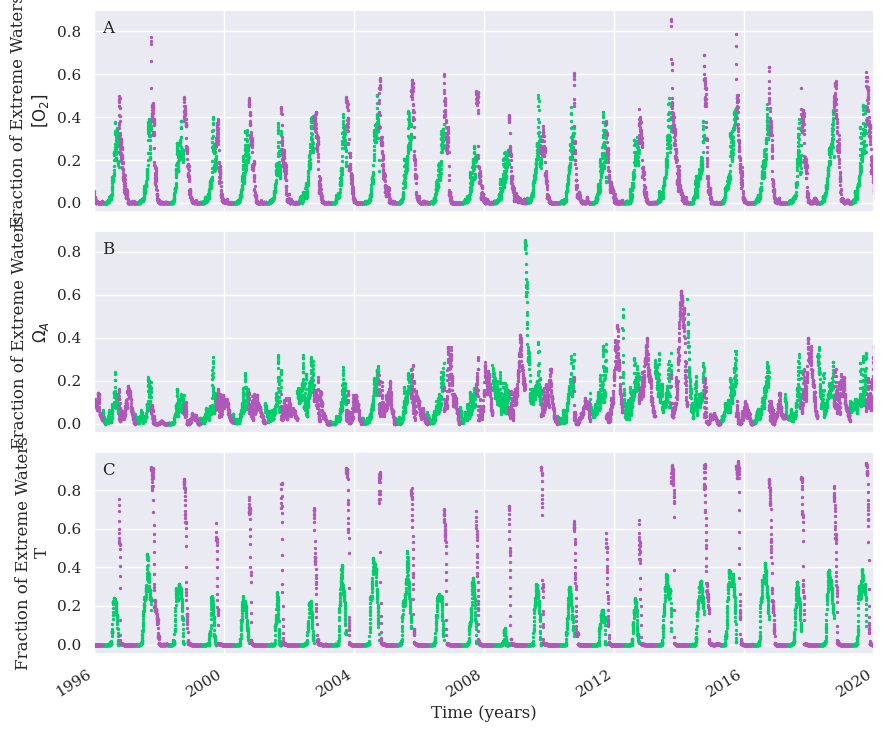

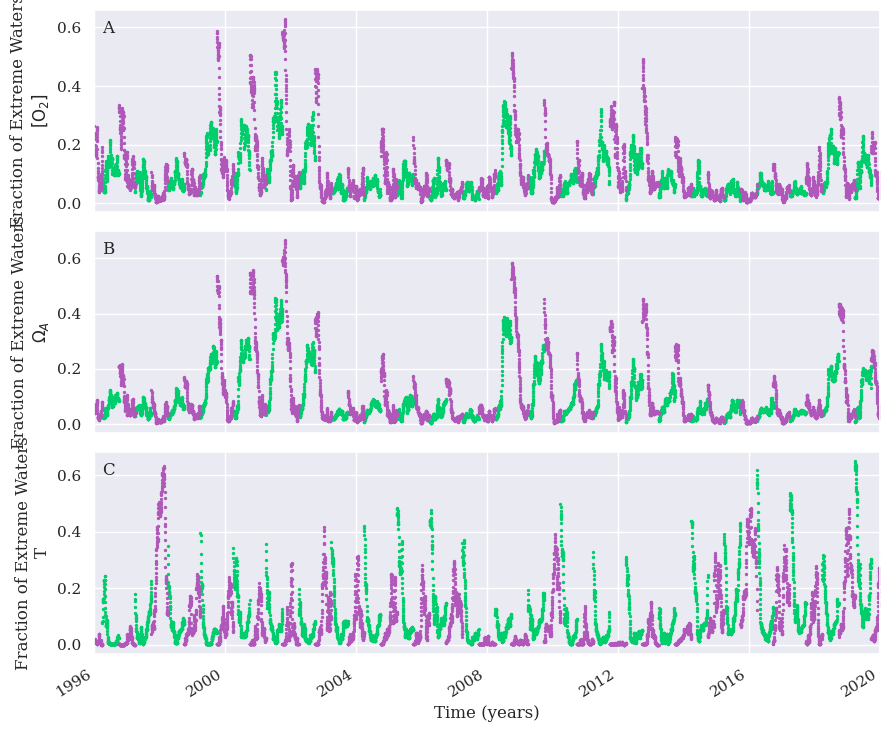

In [51]:
# Calculate extreme thresholds by upwelling/downwelling season and plot timeseries of percentage extremes
downwelling_months = [10, 11, 12, 1, 2, 3]
upwelling_months   = [4, 5, 6, 7, 8, 9]
timeseries_vars = ['O2','OmegaA','T']
hist_kwargs = {
    'alpha':0.5,
    'density':True,
    'bins':100
}

base_percentile = 0.1
percentiles = {
    'O2':base_percentile,
    'OmegaA':base_percentile,
    'T':1-base_percentile
}
at=0.01
bt=0.95
def calculate_threshold(ds, percentile, nbins=1000):
    data = ds.to_numpy().flatten()
    hist, edges = np.histogram(data, bins=nbins, density=True)
    cdf = integrate.cumtrapz(hist,edges[1:])
    return np.interp(percentile, cdf, edges[2:])    

def calc_extremes(ds, thresholds, vars):
    """Calculate which points in the domain exceed multiple thresholds"""
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
    npts = len(ds.stacked_y_x)
    frac_extreme = is_extreme.sum('stacked_y_x')/npts
    return frac_extreme

def plot_fraction_extreme(ax, ds, thresholds, vars, plot_months, extreme_is_low, label,color):
    frac_extreme = calc_extremes(ds, thresholds, vars)
    frac_extreme = frac_extreme.where(frac_extreme['time.month'].isin(plot_months))
    x=frac_extreme.time
    
    #print(x[0],type(x[0]))
    #print(type(np.timedelta64(1, 'D')))
    #print((x[1]-x[0])/np.timedelta64(1, 'D'))
    y=frac_extreme
    # make a dataframe with groups separated that are over an hour apart
    data = []
    g = 0
    for i in range(len(x)):
        x0 = x[i].values
        #print('xo', x0)
        y0 = y[i].values
        if i < (len(x)-1):
            x1 = x[i+1]
            td = x1 - x0
            #print(td)
            elapsed_days = td/np.timedelta64(1, 'D')
            
            if elapsed_days < 2:
                
                data.append([x0,y0, g])
            else:
                data.append([x0,y0, g])
                g+=1
        else:
            data.append([x0,y0, g])

    df = pd.DataFrame(data, columns=['x', 'y', 'group'])
    with open(label+var +'.pickle', 'wb') as handle:
            pickle.dump(df, handle)
    # draw a plot
    #for i, dfg in df.groupby('group'):
     #   print(i)
      #  print(dfg['x'].values)
       # ax.plot(dfg['x'], dfg['y'], c=color)
    ax.scatter(frac_extreme.time, frac_extreme, label=label, s=2, color=color)
    #ax.bar(frac_extreme.time, frac_extreme, label=label, color=color)

upwelling = {}
downwelling = {}

thresholds = {}

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        thresholds[cluster_label] = {}
        thresholds[cluster_label]['upwelling'] = {}
        thresholds[cluster_label]['downwelling'] = {}
        ds_months = cluster_ds.groupby('time.month')
        
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')
                   
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(Hf,Wf))
        for idx, var in enumerate(timeseries_vars):         
            percentile = percentiles[var]
            upwelling_threshold = calculate_threshold(upwelling_ds[var],percentile)
            downwelling_threshold = calculate_threshold(downwelling_ds[var],percentile)
            thresholds[cluster_label]['upwelling'][var] = upwelling_threshold
            thresholds[cluster_label]['downwelling'][var] = downwelling_threshold
            print(f'\t{var} Upwelling: {upwelling_threshold:.1f}')
            print(f'\t{var} Downwelling: {downwelling_threshold:.1f}')
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                [var],
                upwelling_months,
                percentile == base_percentile,
                f'Upwelling_{cluster_label}',
                color=color1
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                [var],
                downwelling_months,
                percentile == base_percentile,
                f'Downwelling_{cluster_label}',
                color=color2
            )

            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{long_names[var]}')
            if idx==2:
                axs[idx].set_xlabel('Time (years)')
                for label in axs[idx].get_xticklabels():
                    label.set_rotation(32)
                    label.set_horizontalalignment("right")
            plt.axis('tight')
            X=axs[idx].get_xticks()
            plt.xlim([X[1], X[-2]])  
            axs[idx].text(at, bt, subpanel[idx], transform=axs[idx].transAxes,  va='top', fontweight='normal',zorder=1000)


        fig.tight_layout()


see the LinePlots notebook for the line plot instead of scatter

In [ ]:
def calc_concurrent_extremes(ds, thresholds, vars):
    is_extreme = xr.full_like(ds[vars[0]], True, dtype=bool)
    for var in vars:
        if var == 'T':
            is_extreme=is_extreme & (ds[var] >= thresholds[var])
        else:
            is_extreme=is_extreme & (ds[var] <= thresholds[var])
        npts = len(ds.stacked_y_x)
        frac_extreme = is_extreme.sum('stacked_y_x')/npts
        return frac_extreme
    
    

In [ ]:
dual_extreme = list(itertools.combinations(timeseries_vars, 2))
dual_extreme += [('T','O2','OmegaA')]

for cluster_label, cluster_ds in enumerate(clusters_ds):    
    if cluster_label in plot_clusters:
        # For every dataset separate data in upwelling and downwelling months
        upwelling_ds = filter_by_season_and_values(cluster_ds, upwelling_months)    
        downwelling_ds = filter_by_season_and_values(cluster_ds, downwelling_months)    
    
        upwelling[cluster_label] = upwelling_ds.copy()
        downwelling[cluster_label] = downwelling.copy()
        print(f'Cluster label: {cluster_label}')

        
        fig, axs = plt.subplots(len(dual_extreme), 1, sharex=True, figsize=(12,8))
        for idx, vars in enumerate(dual_extreme):         
            plot_fraction_extreme(
                axs[idx],
                upwelling_ds, 
                thresholds[cluster_label]['upwelling'],
                vars,
                upwelling_months,
                True,
                'Upwelling',
                color=color1
                
            )
            plot_fraction_extreme(
                axs[idx],
                downwelling_ds, 
                thresholds[cluster_label]['downwelling'],
                vars,
                downwelling_months,
                True,
                'Downwelling',
                color=color2
                
            )
            axs[idx].set_ylabel(f'Fraction of Extreme Waters\n{vars}')
        fig.tight_layout()

In [52]:
def count_average_length(array):
    """
    Calculate the duration of the times when a point in the cluster is extreme, return the average extreme duration
    """
    binary_string = ''.join(str(bit) for bit in array)
    
    # Split the string into runs of ones using the '0' character as a separator.
    ones_runs = binary_string.split('0')
    
    # Filter out empty strings (if the input binary string starts or ends with 0).
    ones_runs = [run for run in ones_runs if run != '']
    
    # Calculate and store the length of each run of non_zeroes
    run_lengths = [len(run) for run in ones_runs]
    
    mean_length = np.array(run_lengths).mean()
    return np.array([mean_length])

def plot_max_avg_duration(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]
    if var == 'T':
        var_ds = var_ds.where(var_ds > threshold[season][var], 0)
    else:
        var_ds = var_ds.where(var_ds < threshold[season][var], 0)
    var_ds = var_ds.where(cluster_ds['time.month'].isin(season_months), 0)
    max_duration = []
    avg_duration = []
    years = []
    for year, ds_year in var_ds.groupby('time.year'):
        lengths = xr.apply_ufunc(count_average_length, ds_year.load(), input_core_dims = [['time']], vectorize=True)
        max_duration.append(lengths.max(dim='stacked_y_x'))
        avg_duration.append(lengths.mean(dim='stacked_y_x'))
        years.append(year) 
    plt.figure()
    plt.bar(years, max_duration)

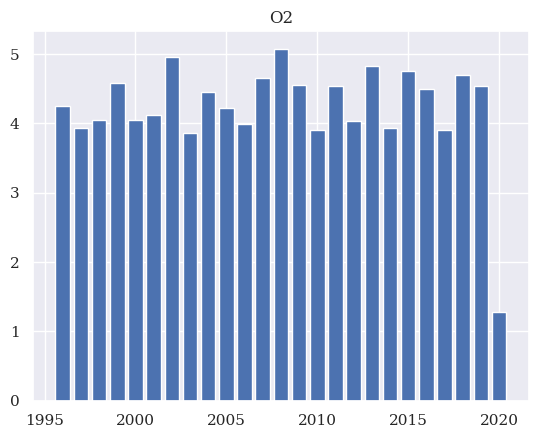

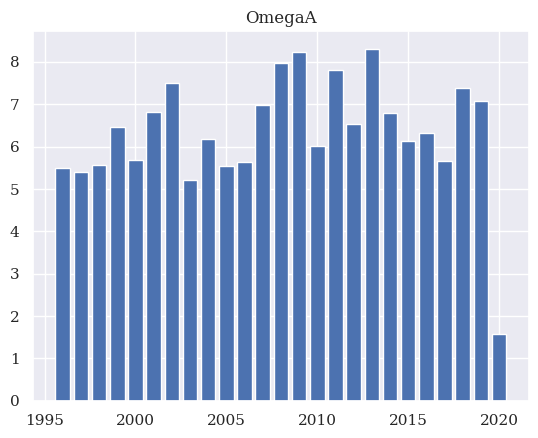

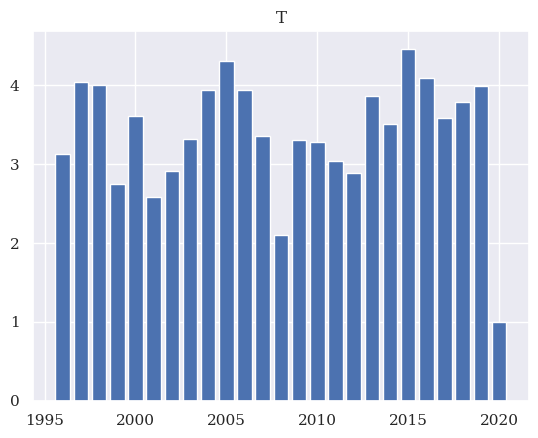

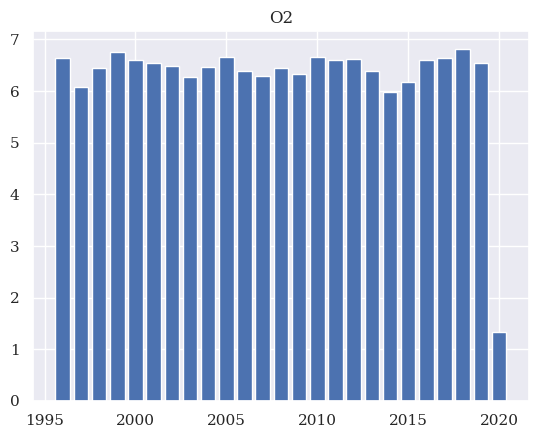

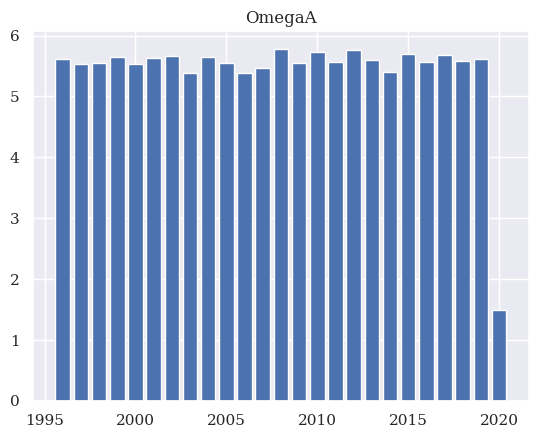

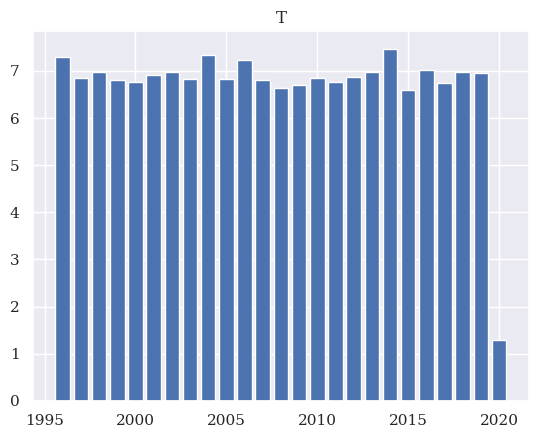

In [53]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        for var in timeseries_vars:
            plot_max_avg_duration(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)
            plt.title(var)

Intensity is defined here as the difference between the threshold and the observed value. For temperature ($T$) this is defined as

$I_T= T - T_{threshold}$

For $\Omega_A$ and $O_2$, the sign is reversed to maintain the convention that a positive intensity is considered an extreme event.

Annual cumulative intensity is defined as the sum of intensity and averaged over every point in the cluster. The average intensity is averaged both in time and over every point of the cluster

In [54]:
def plot_cumulative_intensity(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]

    # Positive intensity implies an extreme event, negative is not
    if var == 'T':
        intensity = var_ds - threshold[season][var]
    else:
        intensity = threshold[season][var] - var_ds
        
    intensity = xr.where(intensity < 0, np.nan, intensity)
    intensity = xr.where(~intensity['time.month'].isin(season_months), np.nan, intensity)

    cumulative_intensity = intensity.groupby('time.year').sum(['time']).mean('stacked_y_x', skipna=True)
    average_intensity = intensity.groupby('time.year').mean(['time', 'stacked_y_x'], skipna=True)

    plt.subplot(1,2,1)
    plt.plot(cumulative_intensity.year, cumulative_intensity)
    plt.title(var)
    plt.subplot(1,2,2)
    plt.plot(cumulative_intensity.year, average_intensity)
    plt.tight_layout()
    


Cluster: 5
Cluster: 7


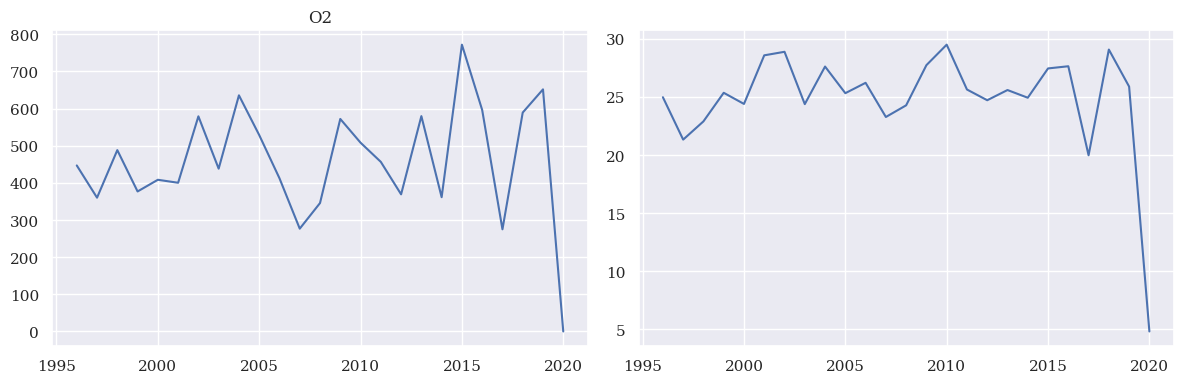

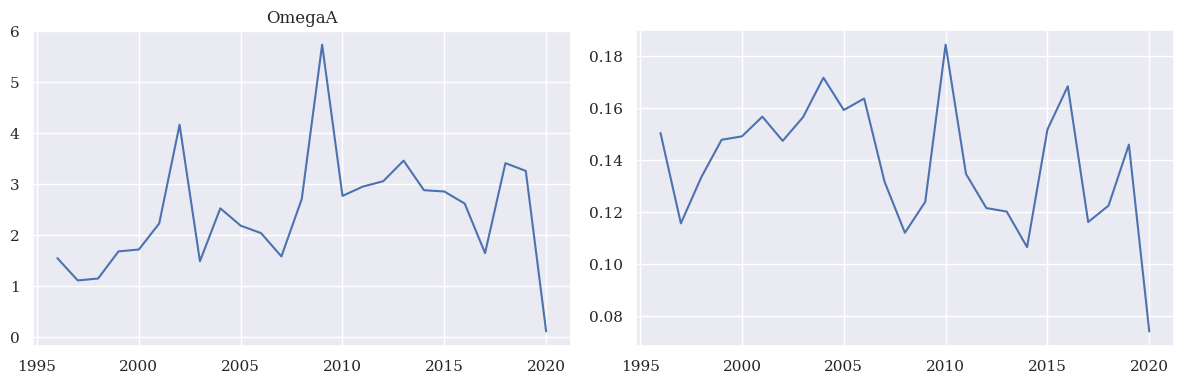

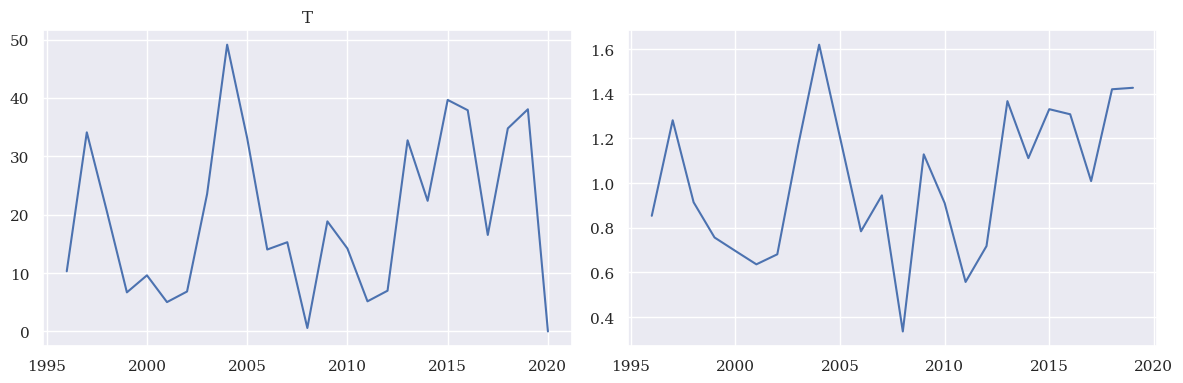

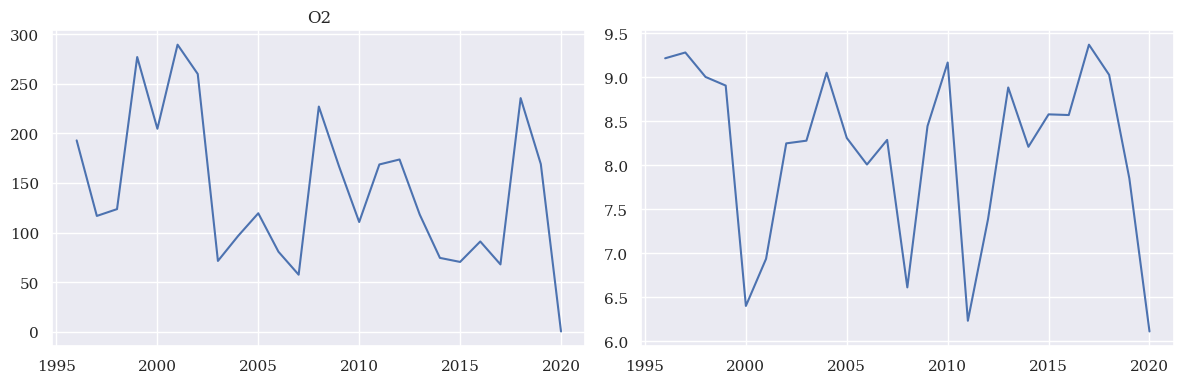

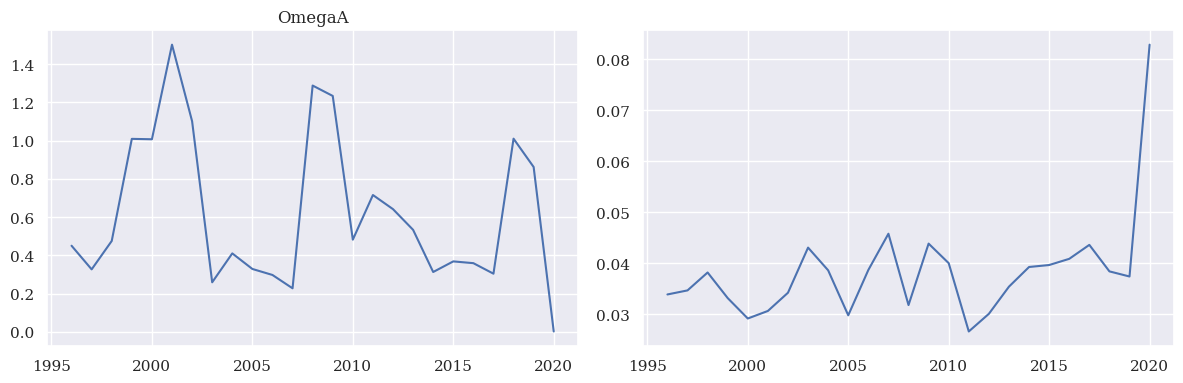

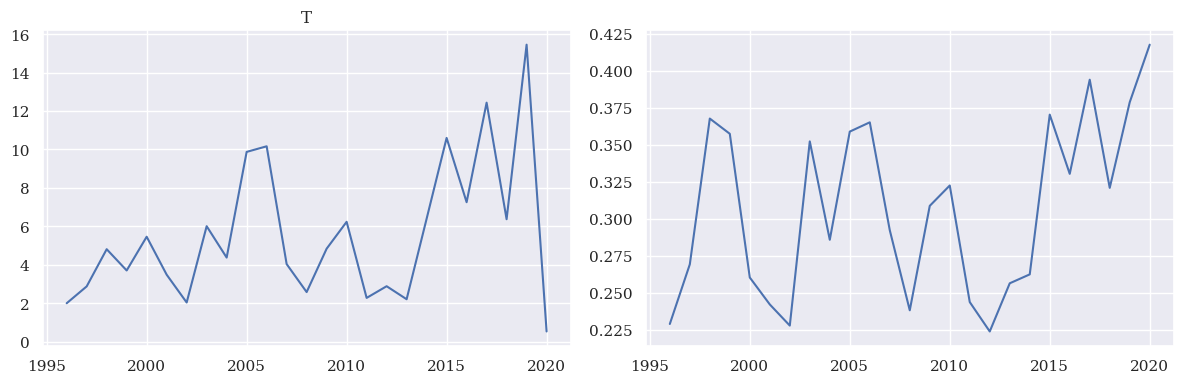

In [55]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        print(f"Cluster: {cluster_label}")
        for var in timeseries_vars:
            plt.figure(figsize=(12,4))
            plot_cumulative_intensity(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)

In [56]:
def calculate_max_severity(intensity):
    """
    Calculate the duration of the times when a point in the cluster is extreme, return the average extreme duration
    """

    intensity_str = ','.join([str(value) for value in intensity])
    
    # Split the string into runs of ones using the '0' character as a separator.
    ones_runs = intensity_str.split(',0.0,')

    run_severity = []
    # Calculate and store the length of each run of non_zeroes
    for run in ones_runs:
        values = np.asarray(run.split(','), dtype=float)
        run_severity.append(np.sum(values))

    if len(run_severity)>0:
        max_severity = np.max(run_severity)
        return np.array([max_severity])
    else:
        return np.array([0.])

def plot_max_severity(cluster_ds, var, threshold, season, season_months):
    var_ds = cluster_ds[var]
    if var == 'T':
        var_ds = var_ds - threshold[season][var]
    else:
        var_ds = threshold[season][var] - var_ds
    var_ds = var_ds.where(var_ds > 0, 0)
    var_ds = var_ds.where(cluster_ds['time.month'].isin(season_months), 0)
    max_duration = []
    avg_duration = []
    years = []
    
    for year, ds_year in var_ds.groupby('time.year'):
        lengths = xr.apply_ufunc(calculate_max_severity, ds_year.load(), input_core_dims = [['time']], vectorize=True)
        max_duration.append(lengths.max(dim='stacked_y_x'))
        avg_duration.append(lengths.mean(dim='stacked_y_x'))
        years.append(year) 
    plt.figure()
    plt.bar(years, max_duration)

calculate_max_severity(cluster_ds.isel(stacked_y_x=1000).T.values)

array([59748.8093756])

In [57]:
test = ','.join([str(value) for value in cluster_ds.isel(stacked_y_x=1000).T.values])
np.array([float(value) for value in test.split('0.0')[0].split(',')])

array([6.7631702, 6.8174872, 6.8402653, ..., 7.294377 , 7.2911153,
       7.275326 ])

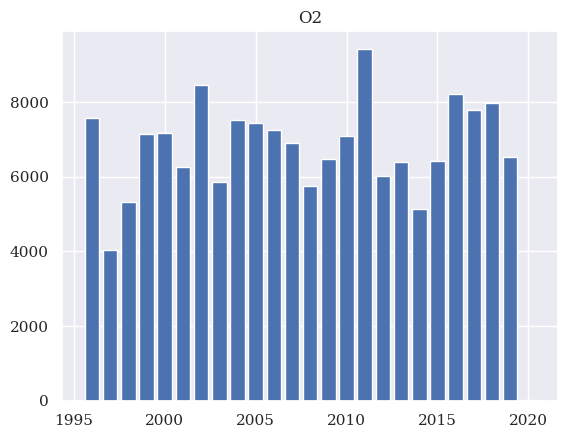

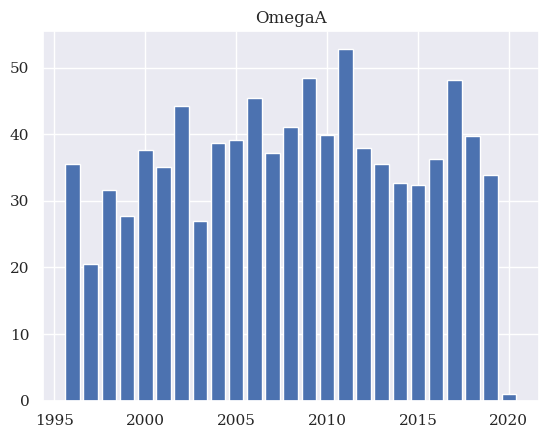

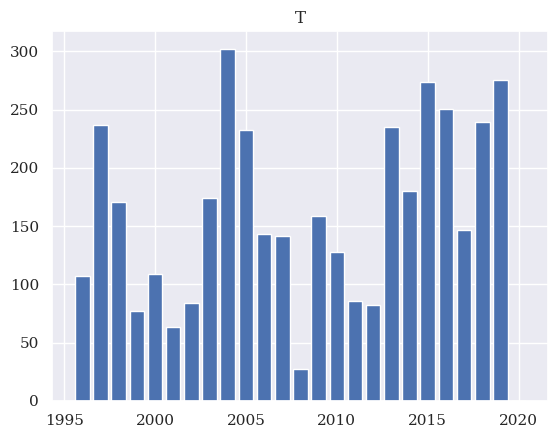

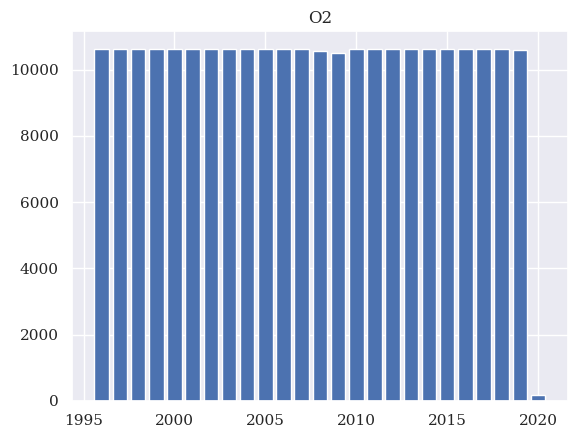

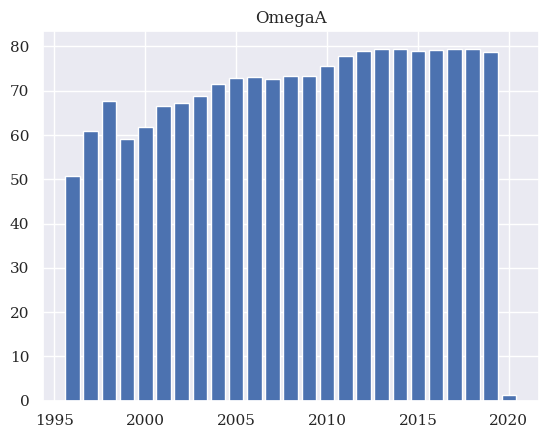

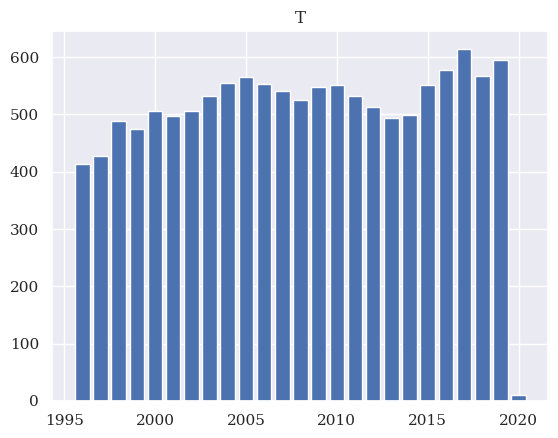

In [58]:
for cluster_label, cluster_ds in enumerate(clusters_ds):
    if cluster_label in plot_clusters:
        for var in timeseries_vars:
            plot_max_severity(cluster_ds, var, thresholds[cluster_label], 'upwelling', upwelling_months)
            plt.title(var)